In [1]:
%matplotlib inline
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import toc_trends_analysis as resa2_trends
from collections import defaultdict
from scipy.stats import theilslopes

plt.style.use('ggplot')

In [2]:
# Connect to NIVABASE
eng = nivapy.da.connect()

Connection successful.


# TOC trends - October 2018 (Part 3: Climate data)

This notebook performs some further cleaning of the trends data and also estimates updated climate trends. The workflow is based on that described [here](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_trends_oct_2016_part3.ipynb).

## 1. Site elevations

I have manually transferred the site elevations from the previous work here

    ...\ICP_Waters\TOC_Trends_Analysis_2015\CRU_Climate_Data\toc_trends_sites_for_climate_update_elev.xlsx
    
to the new site codes here

    ...ICP_Waters\TOC_Trends_Analysis_2015\update_autumn_2018\toc_trends_oct18_stations.xlsx
    
The code below adds these elevations to the database, so they are stored for future reference.

In [3]:
# Read station data
stn_path = r'../../update_autumn_2018/toc_trends_oct18_stations.xlsx'
stn_df = pd.read_excel(stn_path, sheet_name='Data')

In [ ]:
## Update stations table
#with eng.begin() as conn: 
#    for idx, row in stn_df.iterrows():
#        # Add new vals to dict
#        var_dict = {'elev':row['elevation'],
#                    'stn_id':row['station_id']}
#
#        # Update table
#        sql = ("UPDATE resa2.stations "
#               "SET altitude = :elev "
#               "WHERE station_id = :stn_id")
#        conn.execute(sql, **var_dict)  

## 2. Read gridded elevation data

The code below compares the measured station elevations to the pixel elevations in the 0.5 degree global topography dataset used for the climate workflow. Differences between actual elevations and pixel elevations will be used to correct temperature values later in this notebook.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  


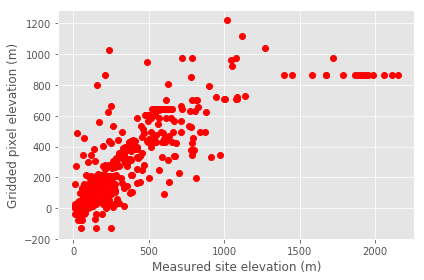

In [4]:
# Read elev data
nc_file = r'../../CRU_Climate_Data/elevation/elev.0.5-deg.nc'
ds = xr.open_dataset(nc_file)

# Shift negative in stn_df lons to match lons in elev file
lon_shift = stn_df['longitude'].values.copy()           # Copy lon values
lon_shift[lon_shift<0] = lon_shift[lon_shift<0] + 360   # Shift
stn_df['lon_shift'] = lon_shift                         # New column     

# Extract elevation data
dsloc = ds.sel_points(lon=stn_df['lon_shift'].values,
                      lat=stn_df['latitude'].values,
                      method='nearest',
                      dim=stn_df['station_id'])  # Use stn ids to index points in result

# Convert to df
elev_df =  dsloc['data'].to_dataframe()

# Rename cols
elev_df.columns = ['grid_lat', 'grid_lon', 'px_elev_m']

# Reset index and tidy
elev_df.reset_index(inplace=True)
del elev_df['time']

# Join to stn_df
stn_df = pd.merge(stn_df, elev_df, how='left', on='station_id')

# Get cols of interest
stn_df = stn_df[['station_id', 'station_code', 'station_name', 
                 'latitude', 'longitude', 'lon_shift',
                 'grid_lat', 'grid_lon', 'elevation', 'px_elev_m']]

# Plot
fig = plt.figure(figsize=(6,4))
plt.plot(stn_df['elevation'], stn_df['px_elev_m'], 'ro')
plt.xlabel('Measured site elevation (m)')
plt.ylabel('Gridded pixel elevation (m)')
plt.tight_layout()

## 3. Extract and aggregate climate data

In [5]:
# Read all the netCDF files and combine into a single dataset
nc_path = (r'../../CRU_Climate_Data/netcdf/v3.26/*.nc')
ds = xr.open_mfdataset(nc_path,
                       chunks={'lat': 90, 'lon': 90})

# Excel file for output
out_xls = r'../../update_autumn_2018/results/cru_climate_summaries.xlsx'

# Create writer object
writer = pd.ExcelWriter(out_xls)

# Define variables and period of interest
var_list = ['pre', 'tmp']
per_list = ['ann', 'jja', 'jas']

# Dict mapping vars and pers to freqs and stats
attrs_dict = {('pre', 'ann'):['A', 'sum'],
              ('pre', 'jja'):['Q-FEB', 'sum'],
              ('pre', 'jas'):['Q-MAR', 'sum'],
              ('tmp', 'ann'):['A', 'mean'],
              ('tmp', 'jja'):['Q-FEB', 'mean'],
              ('tmp', 'jas'):['Q-MAR', 'mean']}

# Loop over data
for var in var_list:
    for per in per_list:  
        # Resample to desired resolution
        if attrs_dict[(var, per)][1] == 'mean':
            ds2 = ds.resample(time=attrs_dict[(var, per)][0]).mean()
        else:
            ds2 = ds.resample(time=attrs_dict[(var, per)][0]).sum()

        # Extract point data
        ds2 = ds2.sel_points(lon=stn_df['longitude'].values,
                             lat=stn_df['latitude'].values,
                             method='nearest',
                             dim=stn_df['station_id'])

        # Convert to df
        df =  ds2[var].to_dataframe()

        # Add year col (and month col for seasonal)
        df['year'] = df.index.get_level_values('time').year        
        if per != 'ann':
            df['month'] = df.index.get_level_values('time').month
            
        # Tidy
        df.reset_index(inplace=True)

        # If seasonal, get just season of interest
        if per == 'jja':
            # Totals for JJA are associated with month=8
            df = df.query('month==8')
        elif per == 'jas':
            # Totals for JAS are associated with month=9
            df = df.query('month==9')

        # Write to output
        df.to_excel(writer,
                    '%s_%s' % (var, per),
                    index=False)

# Save and tidy
writer.save()
ds.close()
ds2.close()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## 4. Climate trends

In [6]:
# Define variables and periods of interest
var_list = ['pre', 'tmp']
per_list = [[1990, 2016], [1990, 2004], [2002, 2016]]

# Excel file of climate data
clim_xls = r'../../update_autumn_2018/results/cru_climate_summaries.xlsx'

# Output summary stats
out_csv = r'../../update_autumn_2018/results/icpw_climate_stats.csv'

# Output folder for plots
plot_fold = r'../../update_autumn_2018/results/climate_plots'

# Produce plots? (For testing)
make_plots = False

In [7]:
# Get list of sites
stn_list = stn_df['station_id'].unique()

# Dict to store output
data_dict = defaultdict(list)

# Loop over data
for var in var_list:
    for tm in ['ann', 'jja', 'jas']:
        # Open the climate data
        clim_df = pd.read_excel(clim_xls, sheet_name='%s_%s' % (var, tm))
        
        # Loop over stations
        for stn in stn_list:
            # Filter the climate data for this station
            stn_clim_df = clim_df.query('station_id == @stn')
            
            # Set date index
            stn_clim_df.index = stn_clim_df['time']
            del stn_clim_df['time']
            stn_clim_df = stn_clim_df.sort_index()
            
            # Correct temperatures according to lapse rate
            if var == 'tmp':
                # Get elevations
                stn_elev = stn_df.query('station_id == @stn')['elevation'].values[0]
                px_elev = stn_df.query('station_id == @stn')['px_elev_m'].values[0]
                
                # If pixel elev is negative (i.e. in sea), correct back to s.l.
                if px_elev < 0:
                    px_elev = 0
                
                # Calculate temperature difference based on 0.6C/100m
                t_diff = 0.6 * (px_elev - stn_elev) / 100.
                
                # Apply correction
                stn_clim_df['tmp'] = stn_clim_df['tmp'] + t_diff
            
            # Loop over time periods
            for per in per_list:
                # Truncate
                df = stn_clim_df.truncate(before='%s-01-01' % per[0],
                                          after='%s-12-31' % per[1])

                # Only need averages for 1990-2016
                if (per[0]==1990) and (per[1]==2016):
                    # Calculate long-term averages
                    key = '%s_%s_%s-%s_avg' % (var, tm, per[0], per[1])
                    val = df.mean()[var]
                    data_dict[key].append(val)
                
                # Calculate Sen's slope and add to dict
                sslp, icpt, lb, ub = theilslopes(df[var].values, 
                                                 df['year'], 0.95)
                
                key = '%s_%s_%s-%s_slp' % (var, tm, per[0], per[1])
                data_dict[key].append(sslp)
                
                # Calculate MK signif and add to dict
                res = resa2_trends.mk_test(df[var].values, str(stn), var)
                sig = res[3]
                
                key = '%s_%s_%s-%s_sig' % (var, tm, per[0], per[1])
                data_dict[key].append(sig)
                
                # Plot
                if make_plots:
                    plt.plot(df['year'], df[var].values, 'bo-')
                    plt.plot(df['year'],
                             sslp*df['year'] + icpt,
                             'k-')
                    plt.title('%s %s at station %s (%s-%s)' % (tm, var, stn, per[0], per[1]),
                              fontsize=20)

                    # Save
                    png_path = os.path.join(plot_fold, 
                                            '%s_%s_%s_%s-%s.png' % (stn, tm, var, 
                                                                    per[0], per[1]))
                    plt.savefig(png_path, dpi=150)
                    plt.close()

# Build output df
df = pd.DataFrame(data_dict, index=stn_list)

# Reorder columns
cols = df.columns
cols = sorted(cols)
df = df[cols]

# Tidy
df.index.name = 'station_id'
df.reset_index(inplace=True)

# Save
df.to_csv(out_csv)

df.head()

,station_id,pre_ann_1990-2004_sig,pre_ann_1990-2004_slp,pre_ann_1990-2016_avg,pre_ann_1990-2016_sig,pre_ann_1990-2016_slp,pre_ann_2002-2016_sig,pre_ann_2002-2016_slp,pre_jas_1990-2004_sig,pre_jas_1990-2004_slp,...,tmp_jas_1990-2016_slp,tmp_jas_2002-2016_sig,tmp_jas_2002-2016_slp,tmp_jja_1990-2004_sig,tmp_jja_1990-2004_slp,tmp_jja_1990-2016_avg,tmp_jja_1990-2016_sig,tmp_jja_1990-2016_slp,tmp_jja_2002-2016_sig,tmp_jja_2002-2016_slp
0,38103,0.092460,-24.863636,1277.085185,0.045360,-10.300000,0.037667,23.450000,0.234955,-5.3500,...,0.064583,0.921159,0.004762,0.124542,0.129630,11.514716,0.033394,0.056410,0.881835,0.008333
1,38104,0.047761,-21.480000,1298.725926,0.013896,-10.980952,0.165857,10.485714,0.198211,-6.1500,...,0.061538,0.881835,0.009524,0.150750,0.083333,12.518790,0.026988,0.061111,0.654854,0.011111
2,38105,0.047761,-21.480000,1298.725926,0.013896,-10.980952,0.165857,10.485714,0.198211,-6.1500,...,0.061538,0.881835,0.009524,0.150750,0.083333,13.202790,0.026988,0.061111,0.654854,0.011111
3,38106,0.092460,-24.863636,1277.085185,0.045360,-10.300000,0.037667,23.450000,0.234955,-5.3500,...,0.064583,0.921159,0.004762,0.124542,0.129630,11.466716,0.033394,0.056410,0.881835,0.008333
4,38107,0.766525,-2.607692,1178.855556,0.867547,-0.708333,0.552615,-6.188889,0.428480,-2.9875,...,0.057778,0.691463,-0.047619,0.298105,0.133333,14.678025,0.108217,0.047619,0.960483,0.008333


## 5. Join to chemistry data

In [8]:
# Read chem data
csv_path = r'../../update_autumn_2018/results/toc_trends_wide_format.csv'
wide_df = pd.read_csv(csv_path, keep_default_na=False)

# Join climate to trends
clim_df = pd.merge(wide_df, df, how='left', on='station_id')

# Save output
out_path = r'../../update_autumn_2018/results/toc_trends_wide_format_with_climate.csv'
clim_df.to_csv(out_path, index=False, encoding='utf-8')

clim_df.head()

,project_id,project_name,station_id,station_code,station_name,nfc_code,type,continent,country,region,...,tmp_jas_1990-2016_slp,tmp_jas_2002-2016_sig,tmp_jas_2002-2016_slp,tmp_jja_1990-2004_sig,tmp_jja_1990-2004_slp,tmp_jja_1990-2016_avg,tmp_jja_1990-2016_sig,tmp_jja_1990-2016_slp,tmp_jja_2002-2016_sig,tmp_jja_2002-2016_slp
0,4390,ICPW_TOCTRENDS_2018,38085,Tr18_CA01,"Ontario, Algoma Region, Batchawana Lake",,L,NA,Canada,ONT,...,0.075000,0.842705,0.008333,0.585735,0.052381,15.794123,0.099209,0.046667,1.000000,0.000000
1,4390,ICPW_TOCTRENDS_2018,38086,Tr18_CA02,"Ontario, Algoma Region, Wishart Lake",,L,NA,Canada,ONT,...,0.075000,0.842705,0.008333,0.585735,0.052381,16.448123,0.099209,0.046667,1.000000,0.000000
2,4390,ICPW_TOCTRENDS_2018,38087,Tr18_CA03,"Ontario, Algoma Region, Little Turkey Lake",,L,NA,Canada,ONT,...,0.075000,0.842705,0.008333,0.585735,0.052381,16.526123,0.099209,0.046667,1.000000,0.000000
3,4390,ICPW_TOCTRENDS_2018,38088,Tr18_CA04,"Ontario, Algoma Region, Turkey Lake",,L,NA,Canada,ONT,...,0.075000,0.842705,0.008333,0.585735,0.052381,16.544123,0.099209,0.046667,1.000000,0.000000
4,4390,ICPW_TOCTRENDS_2018,38089,Tr18_CA05,"Quebec, Lac Veilleux",,L,NA,Canada,QuMaVt,...,0.056667,0.137646,0.079487,0.298105,-0.041667,14.284840,0.210539,0.019048,0.019872,0.095833
